# ** Do Permanent School Closings in Chicago Increase Crime Rates? **
# By: Dani Valverde and Katherine Tai

In [72]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, RidgeClassifier, RidgeClassifierCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
import matplotlib as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import pathlib
from austen_plots.AustenPlot import AustenPlot

# Introduction
Since 2002, Chicago Public Schools (CPS) has closed at least one school every year between 2002 and 2018. In this report, the question we are aiming to answer is: "What is the effect of school closings on crime rates in the ZIP Codes where schools are closed?"

Previous research has studied the effects of school closings on the students whose schools were closed and on the students' academic performance as a group. However, few studies have studied the short-term and long-term effects of school closings on the neighborhoods where the schools are closed. 

One study, performed by N Brazil, has studied the effects of the 2013 school closings in Chicago. However, this study focused more on the absolute distance of the school in meters and the effect on the community. Further, this study explicitly chose not to focus on the binary variable of whether schools were closed or not closed. In addition, Brazil's study focused exclusively on census-tract level data. Our analysis focuses on Chicago Community Areas, which are larger than census tracts and may reveal differences in crime patterns. Further, we are analyzing the effects of all school closures, including those in years where only 1-2 schools were closed. We hope that analyzing more schools over time will yield revealing into insights into the ways that closing schools affects a community, if at all. 

In particular, the vast majority of schools were closed in 2013. Since it has been almost 10 years since the schools were closed, this time elapsed provides a useful time period for estimating the short-term effects on neighborhoods. Further, because crime data is widely available, it is possible to measure the changes in crime rates in particular zip codes from year-to-year. And, because some community areas did not have schools closed, it is possible to determine how much of a change in crime is due to citywide trends, and how much can be attributed to the particular school closing. 

# Data 
We utilized publicly available data from the City of Chicago Data Portal about Crime Statistics since 2001 by Zip Code. There were also publicly available lists of school closings. Combining the dates and ZIP Codes of school closings and the crime rates for those ZIP codes and years, it is possible to measure the effect of these school closings within a given community area within the city of Chicago.

Community areas are defined geographic areas set by the City of Chicago. They are  static, larger than census tracts, and their boundaries do not change as often as city wards, and are more geographically precise than ZIP Codes. 

One of the challenges in answering this question is identifying confounders. Previous research has shown that overall economic indicators such as unemployment rate and economic growth, as well as the proportion of males ages 15-25 are strong predictors for crime rates. Some of the often stated reasons for schools closing are poor performance and population declines. 

Therefore, we calculated the 

# Methodology
To identify the causal estimand of interest, we utilized a Double Machine Learning approach. In the figures below, we show the results of a linear regression. 
When we adjusted for confounders, we found that 

For estimation, we utilized a Difference in Differences approach to estimating the data.

One of the challenges with this analysis was adjusting for observed and unobserved confounders. Social characteristics such as poverty rates, household income, college attainment rates are all predictors of crime. 

In addition to our identification and estimation techniques, we also conducted sensitivity analysis

In [ ]:
# could do cross fitting here? Idt it will work tho 

In [ ]:
# Double ML Library Estimation Procedure 

In [84]:
crime_data = pd.read_csv("CLEANED_DATA.csv")

RANDOM_SEED = 12345
np.random.seed(RANDOM_SEED)


def find_estimators(year):
    """
    Finds ATT and ATE estimator under diff in diff for given year of school closings
    Input:
        year (string): year of school closing
    Returns:
        Prints ATT and ATE
    """

    treatment, outcome, confounders = define_variables(year)

    # finds best Q and g nuisance functions
    Q_model = find_Q_model(treatment, outcome, confounders)
    g_model = find_g_model(treatment, outcome, confounders)

    g = treatment_k_fold_fit_predict(g_model, X=confounders, A=treatment, n_splits=7)

    Q0, Q1 = outcome_k_fold_fit_predict(Q_model, X=confounders, y=outcome, \
        A=treatment, n_splits=10, output_type='continuous')

    data_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})
    data_nuisance_estimates.head()

    tau_hat_att, std_hat_att = att_aiptw(**data_nuisance_estimates)
    print(f"The ATT estimate is {tau_hat_att} pm {1.96*std_hat_att}")

    in_treated = data_nuisance_estimates['A']==1
    treated_estimates = data_nuisance_estimates[in_treated]
    tau_hat_ate, std_hat_ate = ate_aiptw(**treated_estimates)
    print(f"The ATE estimate is {tau_hat_ate} pm {1.96*std_hat_ate}")

    # address overlap issues here 
    new_g = data_nuisance_estimates['g']
    in_overlap_popluation = (new_g < 0.90)
    overlap_data_and_nuisance = data_nuisance_estimates[in_overlap_popluation]
    tau_hat, std_hat = att_aiptw(**overlap_data_and_nuisance)
    print(f"The ATT estimate with restricted population is {tau_hat} pm {1.96*std_hat}")

    # point estimate without covariate correction
    outcome[treatment==1].mean()-outcome[treatment==0].mean()

    # perform sensitivity analysis and plot
    sensitivity_analysis(treatment, outcome, confounders, year, g_model, Q_model)


def define_variables(year):
    """
    Define treatment and outcome for a given year
    Input:
        year (string): year of school closing
    
    Return:
        treatment
        outcome
        confounders
    """

    outcome_year = int(year) + 1

    treatment = crime_data["Treatment_" + year]
    outcome = crime_data[str(outcome_year) + "_cr_per_100k"]
    confounders = crime_data[["Birth Rate", "Pop_" + year, "Assault (Homicide)", 
        "Below Poverty Level", "Per Capita Income", "Unemployment", "Males_15_25", "MED_AGE", "WHITE", "HISP", "BLACK", "ASIAN", "NOT_ENGLISH"]]

    return treatment, outcome, confounders


def find_Q_model(treatment, outcome, confounders):
    """
    Finds model for conditional expected outcome that minimizes MSE, comparing
    random forest, gradient boosting, linear regression, k nearest neighbors,
    and baseline
    Inputs:
        treatment
        outcome
        confounders
    Returns:
        Prints out MSE under each model
    """

    X_w_treatment = confounders.copy()
    X_w_treatment['treatment'] = treatment
    X_train, X_test, Y_train, Y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)

    # random_forest
    random_forest_Q = RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)
    random_forest_Q.fit(X_train, Y_train)
    RF_Y_Pred = random_forest_Q.predict(X_test)

    test_mse_rf = mean_squared_error(RF_Y_Pred, Y_test)
    print(f"Test MSE of random forest model {test_mse_rf}") 

    # gradient boosting 
    xgb_Q = XGBRegressor().fit(X_train, Y_train)
    XGB_Y_Pred = xgb_Q.predict(X_test)

    test_mse_xgb = mean_squared_error(XGB_Y_Pred, Y_test)
    print(f"Test MSE of gradient boosting model {test_mse_xgb}") 

    # linear regression 
    regression_Q = LinearRegression().fit(X_train, Y_train)
    regression_Y_Pred = regression_Q.predict(X_test)

    test_mse_lr = mean_squared_error(regression_Y_Pred, Y_test)
    print(f"Test MSE of linear regression model {test_mse_lr}") 

    # k nearest neighbors 
    knn_Q = KNeighborsRegressor().fit(X_train, Y_train)
    knn_Y_Pred = knn_Q.predict(X_test)
    test_mse_knn = mean_squared_error(knn_Y_Pred, Y_test)
    print(f"Test MSE of k-nearest neighbors model {test_mse_knn}")

    # baseline MSE
    baseline_mse = mean_squared_error(Y_train.mean()*np.ones_like(Y_test), Y_test)
    print(f"Test MSE of no-covariate model {baseline_mse}")

    if min(test_mse_rf, test_mse_xgb, test_mse_lr, test_mse_knn) == test_mse_rf:
        return RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)
    elif min(test_mse_rf, test_mse_xgb, test_mse_lr, test_mse_knn) == test_mse_xgb:
        return XGBRegressor()
    elif min(test_mse_rf, test_mse_xgb, test_mse_lr, test_mse_knn) == test_mse_lr:
        return LinearRegression()
    else:
        return KNeighborsRegressor()


def find_g_model(treatment, outcome, confounders):
    """
    Finds model for propensity score that minimizes cross entropy, comparing
    random forest, gradient boosting, logistic regression, and baseline
    Inputs:
        treatment
        outcome
        confounders
    Returns:
        Prints out CE under each model
    """

    X_train, X_test, A_train, A_test = train_test_split(confounders, treatment, test_size=0.2)

    # random forest 
    random_forest_g = RandomForestClassifier(n_estimators=100, max_depth=2)
    random_forest_g.fit(X_train, A_train)
    RF_A_Pred = random_forest_g.predict_proba(X_test)[:,1]
    test_ce_rf = log_loss(A_test, RF_A_Pred)
    print(f"Test CE of random forest model {test_ce_rf}") 

    # gradient boosting 
    xgb_g = XGBClassifier().fit(X_train, A_train)
    XGB_A_Pred = xgb_g.predict_proba(X_test)
    test_ce_xgb = log_loss(A_test, XGB_A_Pred)
    print(f"Test CE of gradient boosting model {test_ce_xgb}") 

    # logistic regression 
    regression_g = LogisticRegressionCV(solver = "liblinear", max_iter=1000).fit(X_train, A_train)
    regression_A_Pred = regression_g.predict_proba(X_test)
    test_ce_lr = log_loss(A_test, regression_A_Pred)
    print(f"Test CE of logistic regression model {test_ce_lr}") 

    # k nearest neighbors 
    knn_Q = KNeighborsClassifier().fit(X_train, A_train)
    knn_A_Pred = knn_Q.predict_proba(X_test)
    test_ce_knn = log_loss(A_test, knn_A_Pred)
    print(f"Test CE of k-nearest neighbors model {test_ce_knn}")

    # baseline CE
    baseline_cross_entropy = log_loss(A_test, A_train.mean()*np.ones_like(A_test))
    print(f"Test CE of no-covariate model {baseline_cross_entropy}")

    if min(test_ce_rf, test_ce_xgb, test_ce_lr, test_ce_knn) == test_ce_rf:
        return RandomForestClassifier(n_estimators=100, max_depth=2)
    elif min(test_ce_rf, test_ce_xgb, test_ce_lr) == test_ce_xgb:
        return XGBClassifier()
    elif min(test_ce_rf, test_ce_xgb, test_ce_lr, test_ce_knn) == test_ce_lr:
        return LogisticRegressionCV(max_iter=1000)
    else:
        return KNeighborsClassifier()


# Use cross fitting to get predicted outcomes and propensity scores for each unit
def treatment_k_fold_fit_predict(g_model, X:pd.DataFrame, A:np.array, n_splits:int):
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    for train_index, test_index in kf.split(X,A):
        X_train = X.loc[train_index]
        A_train = A.loc[train_index]
        g_model.fit(X_train, A_train)

        predictions[test_index] = g_model.predict_proba(X.loc[test_index])[:,1]

    assert np.isnan(predictions).sum() == 0
    return predictions

def outcome_k_fold_fit_predict(q_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1

    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        q_model.fit(X_train, y_train)

        if output_type == 'binary':
            predictions0[test_index] = q_model.predict_proba(X0.loc[test_index])[:, 1]
            predictions1[test_index] = q_model.predict_proba(X1.loc[test_index])[:, 1]
        elif output_type == 'continuous':
            predictions0[test_index] = q_model.predict(X0.loc[test_index])
            predictions1[test_index] = q_model.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1


def att_aiptw(Q0, Q1, g, A, Y, prob_t=None):
    """
    Finds Double ML estimator for ATT
    """

    if prob_t is None:
        prob_t = A.mean()

    tau_hat = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0)).mean()/ prob_t

    scores = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0) - tau_hat*A) / prob_t
    n = Y.shape[0]
    std_hat = np.std(scores) / np.sqrt(n)
    
    return tau_hat, std_hat


def ate_aiptw(Q0, Q1, g, A, Y, prob_t=None):
    """
    Finds Double ML estimator for ATE
    """
    tau_hat = (Q1-Q0 + A*(Y-Q1)/g - (1-A) * (Y-Q0)/(1-g)).mean()
    
    scores = Q1 - Q0 + A*(Y-Q1)/g - (1-A) * (Y-Q0)/(1-g) - tau_hat
    n = Y.shape[0]
    std_hat = np.std(scores) / np.sqrt(n)
    
    return tau_hat, std_hat


def sensitivity_analysis(treatment, outcome, confounders, year, g_model, Q_model):
    """
    Perform Austen Plots sensitivity analysis
    Input:
        treatment
        outcome
        confounders
        year (string)
    Return:
        plot
    """

    covariate_groups = {
        'economic': ["Per Capita Income", "Below Poverty Level"],
        'population': ["Birth Rate", "Pop_" + year, "Assault (Homicide)"], 
        'demographics': ["Males_15_25", "MED_AGE", "WHITE", "HISP", "BLACK", "ASIAN"],
        'language': "NOT_ENGLISH"}

    # for each covariate group, refit models without using that group 
    nuisance_estimates = {}
    for group, covs in covariate_groups.items():
        remaining_confounders = confounders.drop(columns=covs)

        g = treatment_k_fold_fit_predict(g_model, X=remaining_confounders, A=treatment, n_splits=5)
        Q0, Q1 = outcome_k_fold_fit_predict(Q_model, X=remaining_confounders, y=outcome, A=treatment, n_splits=5, output_type="continuous")
        data_nuisance_estimates = pd.DataFrame(({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome}))
        nuisance_estimates[group] = data_nuisance_estimates

    data_nuisance_path = 'data_nuisance_estimates.csv'
    covariate_dir_path = 'covariates/'

    austen_data_nuisance = convert_to_austen_format(data_nuisance_estimates)
    austen_data_nuisance.to_csv(data_nuisance_path, index=False)

    pathlib.Path(covariate_dir_path).mkdir(exist_ok=True)
    for group, nuisance_estimate in nuisance_estimates.items():
        austen_nuisance_estimate = convert_to_austen_format(nuisance_estimate)
        austen_nuisance_estimate.to_csv(os.path.join(covariate_dir_path, group+'.csv'), index=False)

    # Austen Plots 
    target_bias = 2500

    ap = AustenPlot(data_nuisance_path, covariate_dir_path)
    p, plot_coords, variable_coords = ap.fit(bias=target_bias)

    return p


def convert_to_austen_format(nuisance_estimate_df: pd.DataFrame):
    austen_df = pd.DataFrame()
    austen_df['y']=nuisance_estimate_df['Y']
    austen_df['t']=nuisance_estimate_df['A']
    austen_df['g']=nuisance_estimate_df['g']
    A = nuisance_estimate_df['A']
    austen_df['Q']=A*nuisance_estimate_df['Q1'] + (1-A)*nuisance_estimate_df['Q0']

    return austen_df


In [ ]:
# Differences in Differences Estimation 

# Results

# Sensitivity Analysis

Test MSE of random forest model 10158609.936705
Test MSE of gradient boosting model 16595581.235792354
Test MSE of linear regression model 12224180.027058337
Test MSE of k-nearest neighbors model 10368460.732500002
Test MSE of no-covariate model 55854510.23611112
Test CE of random forest model 0.4933021779266046
[16:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test CE of gradient boosting model 0.7362210633109498
Test CE of logistic regression model 1.4376871661628228
Test CE of k-nearest neighbors model 2.511418956020856
Test CE of no-covariate model 0.7683249487440789


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Fitting main dataset


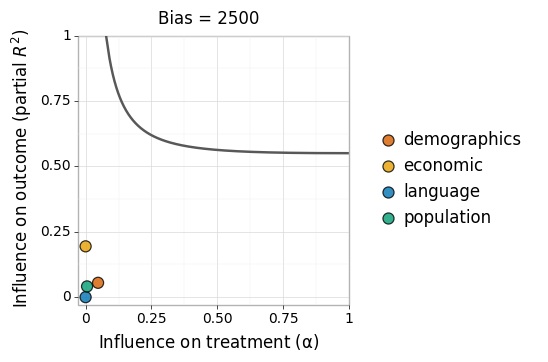

<ggplot: (8789592691655)>

In [85]:
treatment, outcome, confounders = define_variables("2013")
Q_model = find_Q_model(treatment, outcome, confounders)
g_model = find_g_model(treatment, outcome, confounders)
sensitivity_analysis(treatment, outcome, confounders, "2013", g_model, Q_model)

In [77]:
find_estimators('2013')

Test MSE of random forest model 14155863.810948499
Test MSE of gradient boosting model 43131858.23850457
Test MSE of linear regression model 20605082.538639933
Test MSE of k-nearest neighbors model 6671687.125000001
Test MSE of no-covariate model 31224242.875
Test CE of random forest model 0.3998646065613375
[16:09:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test CE of gradient boosting model 0.53134839219274
Test CE of logistic regression model 0.558355458787838
Test CE of k-nearest neighbors model 2.4402043133215834
Test CE of no-covariate model 0.5684994090355333


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


The ATT estimate is 2914.946039345714 pm 2678.8975672388424
The ATE estimate is 5732.386109524821 pm 5414.587797451961
The ATT estimate with restricted population is 2914.946039345714 pm 2678.8975672388424
Fitting main dataset


# Additional Considerations
One of the most obvious considerations in our analysis is that the factors that lead to crime are not precisely understood. As stated earlier, there are a few indicators 